In [1]:
import math
import numpy as np
from numpy import nan
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import random

### Julian day Series


In [2]:
jd = []
n = 365
for i in range(n):
    jd.append(i+1)
    
continuous_day = []

for i in jd:
    x = 1
    while x<25:
        continuous_day.append(i+x/24-0.0001)
        x +=1
#continuous_day
df_jd = pd.DataFrame({'Julian Day': continuous_day})
#print(df_jd.head(50))
df_jd.to_csv(r'F:\North_Changri_Nup\Julian_day.csv')

## Lapse Rate Models


In [3]:
df_day_9tiles = pd.read_csv(r'F:\North_Changri_Nup\Era5Land\9 tile_T_Nov2014-Nov2015.csv')
elevations = [6008.11359, 6104.398402, 6143.32205, 5311.277867, 5581.080203, 5991.622255,
              4646.810231, 4923.782713, 5560.08192]  #uncertainty not known
Julian_day = []
for i in range(1, 364):
    x = 1
    while x <25:
        Julian_day.append(round(i+ x/100, 2))
        x+=1
        
df_day_9tiles['Julian Day'] = Julian_day
df_day_9tiles.head(2)

,Date,Julian Day,"28.1,86.7","28.1,86.8","28.1,86.9","28.0,86.7","28.0,86.8","28.0,86.9","27.9,86.7","27.9,86.8","27.9,86.9"
0,01-12-2014 0:00,1.01,-8.75445,-10.0335,-11.4669,-4.47668,-6.70591,-10.4924,-0.470960,-2.69918,-7.69567
1,01-12-2014 1:00,1.02,-9.25593,-10.5025,-11.9511,-4.27162,-6.61760,-10.8812,0.181771,-2.16623,-7.87332


In [4]:
lapse_rate_hourly = [] #Hourly Lapse rate of the given year
for i in range(8712):
    def func(X, a, c):
        return a*X + c
    
    # X and Ydata
    X = elevations
    Ydata = list(df_day_9tiles.iloc[i, 2:])
    popt, pcov = curve_fit(func, X, Ydata)
    #print(pcov[0][0]**0.5) uncertainty
    lapse_rate_hourly.append((popt[0]  + random.uniform(-pcov[0][0]**0.5,pcov[0][0]**0.5) )*(-1000))
df_day_9tiles['LapseRate'] = lapse_rate_hourly
print(sum(lapse_rate_hourly)/len(lapse_rate_hourly))
df_day_9tiles.head(2)
df_day_9tiles.to_csv(r'F:\North_Changri_Nup\Era5Land\Lapse_rate.csv', index = False)

6.065561303951318


,Date,Julian Day,"28.1,86.7","28.1,86.8","28.1,86.9","28.0,86.7","28.0,86.8","28.0,86.9","27.9,86.7","27.9,86.8","27.9,86.9",LapseRate,Moving_average_lapse_rate
24,02-12-2014 0:00,2.01,-8.26617,-9.21736,-10.4538,-3.22502,-5.27051,-9.36353,1.307555,-0.70140,-6.21154,7.586240,7.150231
25,02-12-2014 1:00,2.02,-8.49661,-9.41429,-10.6802,-3.11945,-5.22686,-9.48738,1.461855,-0.59481,-6.21357,7.692908,7.134672


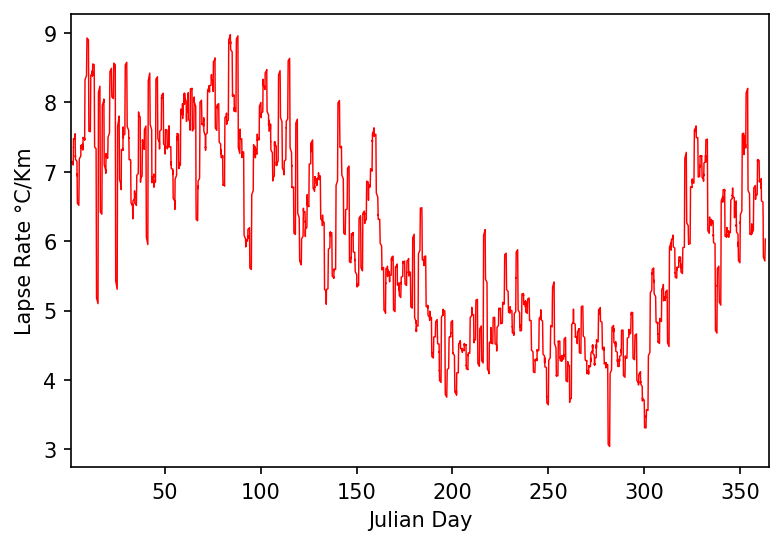

In [5]:
day_for_ave_lapserate = 1
window_size = int(day_for_ave_lapserate*24)
numbers_series = pd.Series(lapse_rate_hourly)
windows = numbers_series.rolling(window_size)
moving_averages = windows.mean()
moving_averages_list = moving_averages.tolist()
without_nans_lr = moving_averages_list[window_size - 1:]

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
df_day_9tiles['Moving_average_lapse_rate'] = moving_averages_list
plt.plot(df_day_9tiles['Julian Day'] ,df_day_9tiles['Moving_average_lapse_rate'], color='red', linewidth=0.7)
plt.xlabel('Julian Day')
plt.ylabel('Lapse Rate °C/Km')
plt.xlim(1,365)
df = df_day_9tiles.iloc[window_size:, :] #df starts with day 2
df.head(2)

## Calculating T at 5470 meter height

In [6]:
df['T_5470_Era']= df['Moving_average_lapse_rate']*(elevations[0] - 5470 )/1000 + df['28.1,86.7']
df.index = np.arange(8712 - 24*day_for_ave_lapserate)
df.to_csv(r'F:\North_Changri_Nup\Era5Land\Hourly_T_lr_Nov2014-Nov2015.csv', index = False)
df.head(2)

<ipython-input-6-d9b8b7bd0382>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['T_5470_Era']= df['Moving_average_lapse_rate']*(elevations[0] - 5470 )/1000 + df['28.1,86.7']


,Date,Julian Day,"28.1,86.7","28.1,86.8","28.1,86.9","28.0,86.7","28.0,86.8","28.0,86.9","27.9,86.7","27.9,86.8","27.9,86.9",LapseRate,Moving_average_lapse_rate,T_5470_Era
0,02-12-2014 0:00,2.01,-8.26617,-9.21736,-10.4538,-3.22502,-5.27051,-9.36353,1.307555,-0.70140,-6.21154,7.586240,7.150231,-4.418534
1,02-12-2014 1:00,2.02,-8.49661,-9.41429,-10.6802,-3.11945,-5.22686,-9.48738,1.461855,-0.59481,-6.21357,7.692908,7.134672,-4.657346


### Calculating 15 Day Bias

In [7]:
t_5470_30min = [] #from Era5Land
for t in df['T_5470_Era']:
    x = 2
    while x > 0:
        t_5470_30min.append(t)
        x-=1
        
df_AWS_T = pd.read_csv(r'F:\North_Changri_Nup\AWS_T_2014-15.csv')
df_AWS_T = df_AWS_T.iloc[day_for_ave_lapserate*48: , :]
df_AWS_T['T_5470_Era'] = t_5470_30min
df_AWS_T['Bias'] = df_AWS_T['Tair'] - df_AWS_T['T_5470_Era']
#df_AWS_T.head(3)
#df_AWS_T.iloc[2697:2702]

In [8]:
bias = df_AWS_T['Bias']
bias_ydays_12plus = []
bias_day = 15

for x in range(0, len(bias), bias_day*48):
    chunk = bias[x:x + bias_day*48]
    if math.isnan(sum(chunk)) == True:
        new_chunk = list(np.array(chunk)[np.logical_not(np.isnan(np.array(chunk)))])
        #print(sum(new_chunk)/len(new_chunk))
        y = bias_day * 24
        while y > 0:
            bias_ydays_12plus.append(sum(new_chunk) / len(new_chunk))
            y = y - 1
    else:
        y = bias_day * 24
        while y > 0:
            bias_ydays_12plus.append(sum(chunk) / len(chunk))
            y = y - 1
df['Bias_15Day'] = bias_ydays_12plus[:8712 - 24*day_for_ave_lapserate]
#df.iloc[4776:4800,:]
df.head(2)

<ipython-input-8-332aba54f93a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Bias_15Day'] = bias_ydays_12plus[:8712 - 24*day_for_ave_lapserate]


,Date,Julian Day,"28.1,86.7","28.1,86.8","28.1,86.9","28.0,86.7","28.0,86.8","28.0,86.9","27.9,86.7","27.9,86.8","27.9,86.9",LapseRate,Moving_average_lapse_rate,T_5470_Era,Bias_15Day
0,02-12-2014 0:00,2.01,-8.26617,-9.21736,-10.4538,-3.22502,-5.27051,-9.36353,1.307555,-0.70140,-6.21154,7.586240,7.150231,-4.418534,2.250074
1,02-12-2014 1:00,2.02,-8.49661,-9.41429,-10.6802,-3.11945,-5.22686,-9.48738,1.461855,-0.59481,-6.21357,7.692908,7.134672,-4.657346,2.250074


### Loading Stake Ablation Data

In [9]:
df_stake_data = pd.read_csv(r'F:\North_Changri_Nup\Stake_Ablation_Data.csv')
df_stake_data['Melt Rate'] = df_stake_data['MB (cm w.e.)']/df_stake_data['Obs_days']
df_stake_data.head(2)

,Stake Name,jd1,jd2,Debris Thickness,Time Period,Elevation,Obs_days,MB (cm w.e.),time_period,Melt Rate
0,CNBL21−14,145,228,6.0,MB avr15_jul15,5471.842,83,97.25,2,1.171687
1,CNBL22−14,2,144,33.0,MB nov14_avr15,5471.822,145,3.60,1,0.024828


### Area Weighted PDD

In [10]:
df_histo = pd.read_csv(r'F:\North_Changri_Nup\ChangriNup_histo.csv')
df_histo
elevation = df_histo['Elevation']
area = df_histo['Area (km2)']
area_weighted_pdd = []
for i in range(len(df_stake_data.index)):  #number of time intervals
    areaXpdd = []   # for each time interval, area*pdd for different elevations of the histogram
    for a, z in zip(area, elevation):  
        try:
            y = list(df['Julian Day']).index(df_stake_data['jd2'][i] + 1.01) #indices of starting and ending day
        except:
            y = 8687
        x = list(df['Julian Day']).index(df_stake_data['jd1'][i] + .01)
        temp_at_z = list(df['Moving_average_lapse_rate'][x:y]*(6008.11359 - z )/1000 + df['28.1,86.7'][x:y] + df['Bias_15Day'][x:y])
        PDD = sum([s for s in temp_at_z if s > 0]) / 24 
        areaXpdd.append(PDD*a)
    area_weighted_pdd.append(sum(areaXpdd)/sum(area))

df_stake_data['pdd_area_weighted'] = area_weighted_pdd
df_stake_data.head(2)

,Stake Name,jd1,jd2,Debris Thickness,Time Period,Elevation,Obs_days,MB (cm w.e.),time_period,Melt Rate,pdd_area_weighted
0,CNBL21−14,145,228,6.0,MB avr15_jul15,5471.842,83,97.25,2,1.171687,105.225896
1,CNBL22−14,2,144,33.0,MB nov14_avr15,5471.822,145,3.60,1,0.024828,3.925073


### Frequency distribution of Debris

In [11]:
df_freq = pd.read_csv(r'F:\North_Changri_Nup\ChangriNup_Frequency_Distribution.csv')
debris_thickness = df_freq['Debris Thickness (cm)']
freq = df_freq['%frequency']
df_freq.head(2)

,Debris Thickness (cm),%frequency
0,5,0.073383
1,15,0.067304


### Calculating Modelled Melt using three models


In [12]:
melt_model1 = [] #modeled melt in cm
melt_model2 = []
melt_model3 = []

for db, pdd in zip(df_stake_data['Debris Thickness'],df_stake_data['pdd_area_weighted']):
    melt_model1.append((5.84*(db**-0.38)*pdd)/10)
    melt_model2.append((5.12*pdd/(1 + db/12.25))/10)
    melt_model3.append((6.82*pdd/(1 + (db/1.23)**2)**0.23)/10)
        
#df_stake_data['Observed_melt'] = list(df_stake_data['MB (cm w.e.)'])
df_stake_data['Model 1 melt']= melt_model1
df_stake_data['Model 2 melt']= melt_model2
df_stake_data['Model 3 melt']= melt_model3
df_stake_data.to_csv(r'F:\North_Changri_Nup\Stake_ablation_modeled_melt.csv', index=False)


rmse1 = (sum((df_stake_data['MB (cm w.e.)']/df_stake_data['Obs_days'] - df_stake_data['Model 1 melt']/df_stake_data['Obs_days'])**2)/31)**0.5
rmse2 = (sum((df_stake_data['MB (cm w.e.)']/df_stake_data['Obs_days'] - df_stake_data['Model 2 melt']/df_stake_data['Obs_days'])**2)/31)**0.5
rmse3 = (sum((df_stake_data['MB (cm w.e.)']/df_stake_data['Obs_days'] - df_stake_data['Model 3 melt']/df_stake_data['Obs_days'])**2)/31)**0.5

## Finding Total Melt

### Observed Total Melt

In [13]:
periodic_total_melt_n = []
for n in range(1,5):
    total_melt_n = [] # melts of nth time period for each db band
    melt_n = []
    db_thickness_n = []
    #obs_day = [145, 83, 31, 102]
    for m, db, time in zip(df_stake_data['MB (cm w.e.)'], df_stake_data['Debris Thickness'], df_stake_data['time_period']):
        if time == n:
            melt_n.append(m)
            db_thickness_n.append(db)
            
    for d,fq in zip(debris_thickness, freq):
        melt_d = []
        for i, j in zip(melt_n, db_thickness_n):
            if d-5 < j < d+5.0001:
                melt_d.append(i)
        if len(melt_d) >0:
            total_melt_n.append(sum(melt_d)/len(melt_d)*(2.7 - 0.92)*fq/100)
    periodic_total_melt_n.append(sum(total_melt_n))        

## Total melt model 1, 2, 3

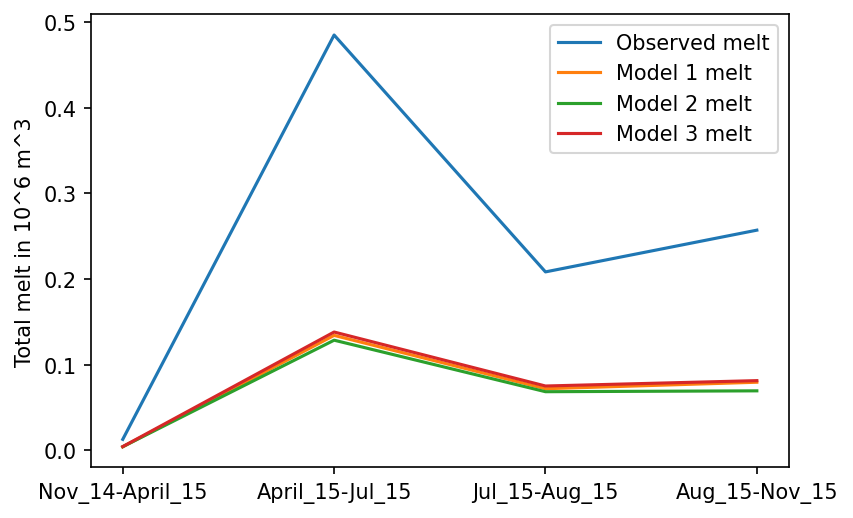

In [14]:
periodic_total_melt_n_model1 = []
for n in range(1,5):
    total_melt_n = [] # melts of nth time period for each db band
    melt_n = []
    db_thickness_n = []
    #obs_day = [145, 83, 31, 102]
    for m, db, time in zip(df_stake_data['Model 1 melt'], df_stake_data['Debris Thickness'], df_stake_data['time_period']):
        if time == n:
            melt_n.append(m)
            db_thickness_n.append(db)
            
    for d,fq in zip(debris_thickness, freq):
        melt_d = []
        for i, j in zip(melt_n, db_thickness_n):
            if d-5 < j < d+5.0001:
                melt_d.append(i)
        if len(melt_d) >0:
            total_melt_n.append(sum(melt_d)/len(melt_d)*(2.7 - 0.92)*fq/100)
    periodic_total_melt_n_model1.append(sum(total_melt_n))


periodic_total_melt_n_model2 = []
for n in range(1,5):
    total_melt_n = [] # melts of nth time period for each db band
    melt_n = []
    db_thickness_n = []
    #obs_day = [145, 83, 31, 102]
    for m, db, time in zip(df_stake_data['Model 2 melt'], df_stake_data['Debris Thickness'], df_stake_data['time_period']):
        if time == n:
            melt_n.append(m)
            db_thickness_n.append(db)
            
    for d,fq in zip(debris_thickness, freq):
        melt_d = []
        for i, j in zip(melt_n, db_thickness_n):
            if d-5 < j < d+5.0001:
                melt_d.append(i)
        if len(melt_d) >0:
            total_melt_n.append(sum(melt_d)/len(melt_d)*(2.7 - 0.92)*fq/100)
    periodic_total_melt_n_model2.append(sum(total_melt_n))



periodic_total_melt_n_model3 = []
for n in range(1,5):
    total_melt_n = [] # melts of nth time period for each db band
    melt_n = []
    db_thickness_n = []
    #obs_day = [145, 83, 31, 102]
    for m, db, time in zip(df_stake_data['Model 3 melt'], df_stake_data['Debris Thickness'], df_stake_data['time_period']):
        if time == n:
            melt_n.append(m)
            db_thickness_n.append(db)
            
    for d,fq in zip(debris_thickness, freq):
        melt_d = []
        for i, j in zip(melt_n, db_thickness_n):
            if d-5 < j < d+5.0001:
                melt_d.append(i)
        if len(melt_d) >0:
            total_melt_n.append(sum(melt_d)/len(melt_d)*(2.7 - 0.92)*fq/100)
    periodic_total_melt_n_model3.append(sum(total_melt_n))
    

plt.plot(['Nov_14-April_15','April_15-Jul_15','Jul_15-Aug_15','Aug_15-Nov_15'], periodic_total_melt_n, label = 'Observed melt')
plt.plot(['Nov_14-April_15','April_15-Jul_15','Jul_15-Aug_15','Aug_15-Nov_15'], periodic_total_melt_n_model1, label = 'Model 1 melt')
plt.plot(['Nov_14-April_15','April_15-Jul_15','Jul_15-Aug_15','Aug_15-Nov_15'], periodic_total_melt_n_model2, label = 'Model 2 melt')
plt.plot(['Nov_14-April_15','April_15-Jul_15','Jul_15-Aug_15','Aug_15-Nov_15'], periodic_total_melt_n_model3, label = 'Model 3 melt')
plt.legend()
plt.ylabel('Total melt in 10^6 m^3')
df_periodic_melt = pd.DataFrame({'observed melt': periodic_total_melt_n,
                                'Model 1 melt': periodic_total_melt_n_model1,
                                'Model 2 melt': periodic_total_melt_n_model2,
                                'Model 3 melt': periodic_total_melt_n_model3})
rmse_1 = (sum((df_periodic_melt['observed melt'] - df_periodic_melt['Model 1 melt'])**2)/4)**0.5
rmse_2 = (sum((df_periodic_melt['observed melt'] - df_periodic_melt['Model 2 melt'])**2)/4)**0.5
rmse_3 = (sum((df_periodic_melt['observed melt'] - df_periodic_melt['Model 3 melt'])**2)/4)**0.5


In [15]:
print('Rmse in cm/day')
print('Rmse1 =' ,rmse1)
print('Rmse2 =' ,rmse2) # in cm/day
print('Rmse3 =' ,rmse3, '\n')
print('Rmse in 10^6 m^3')
print('Rmse_1 =' ,rmse_1)
print('Rmse_2 =' ,rmse_2) # in 10^6 m^3
print('Rmse_3 =' ,rmse_3)

Rmse in cm/day
Rmse1 = 0.9146623149831679
Rmse2 = 0.8948771010118431
Rmse3 = 0.8943861722663685 

Rmse in 10^6 m^3
Rmse_1 = 0.20813140925600354
Rmse_2 = 0.21322661416997346
Rmse_3 = 0.20555339245318938
